#import CNR-EXT dataset

In [1]:
%%shell

# Check if wget, unzip, and tar are installed
which unzip > /dev/null && which wget > /dev/null && which tar > /dev/null || {
    echo "Installing wget, unzip, and tar";
    apt-get update && apt-get install -y wget unzip tar;
}

echo "This command will download and unzip the datasets used in this project."

# 1. CNR-EXT FULL IMAGE dataset
wget "https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT_FULL_IMAGE_1000x750.tar" -O "CNR-EXT_FULL_IMAGE_1000x750.tar"
mkdir -p CNR-EXT_FULL_IMAGE_1000x750
tar -xvf CNR-EXT_FULL_IMAGE_1000x750.tar -C CNR-EXT_FULL_IMAGE_1000x750 && rm CNR-EXT_FULL_IMAGE_1000x750.tar

# 2. CNR-EXT Patches dataset
wget "https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT-Patches-150x150.zip" -O "CNR-EXT-Patches-150x150.zip"
mkdir -p CNR-EXT-Patches-150x150
unzip CNR-EXT-Patches-150x150.zip -d CNR-EXT-Patches-150x150 && rm CNR-EXT-Patches-150x150.zip


Output streaming troncato alle ultime 5000 righe.
  inflating: CNR-EXT-Patches-150x150/PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_11.06_C08_211.jpg  
  inflating: CNR-EXT-Patches-150x150/PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_08.06_C08_214.jpg  
  inflating: CNR-EXT-Patches-150x150/PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_10.36_C08_325.jpg  
  inflating: CNR-EXT-Patches-150x150/PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_16.36_C08_291.jpg  
  inflating: CNR-EXT-Patches-150x150/PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_10.06_C08_283.jpg  
  inflating: CNR-EXT-Patches-150x150/PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_08.36_C08_317.jpg  
  inflating: CNR-EXT-Patches-150x150/PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_15.06_C08_321.jpg  
  inflating: CNR-EXT-Patches-150x150/PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_11.36_C08_255.jpg  
  inflating: CNR-EXT-Patches-150x150/PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_09.36_C08_292.jp

#Utils

In [30]:
import pandas as pd
import re

def extract_info_from_img(path):
    """
    Analisi del nome dell'immagine e estrazione di informazioni da questo.
    :param path: Il percorso del file immagine.
    :return: Informazioni riguardo l'immagine (weather, capture_date, cam_id, capture_time).
    """
    # Definire il pattern per estrarre le informazioni desiderate
    pattern = r'FULL_IMAGE_1000x750/(?P<weather>\w+)/(?P<capture_date>\d{4}-\d{2}-\d{2})/camera(?P<cam_id>\d)/(?P<capture_date_repeat>\d{4}-\d{2}-\d{2})_(?P<capture_time>\d{4})\.jpg'

    # Usare re.search per trovare le corrispondenze
    match = re.search(pattern, path)

    if match:
        # Estrarre le informazioni dalle corrispondenze
        weather = match.group('weather')
        capture_date = match.group('capture_date')
        cam_id = match.group('cam_id')
        capture_time = match.group('capture_time')
        # print(f"WEATHER: {weather}")
        # print(f"CAPTURE_DATE: {capture_date}")
        # print(f"CAM_ID: {cam_id}")
        # print(f"CAPTURE_TIME: {capture_time}")
        return weather, capture_date, cam_id, capture_time
    else:
        raise ValueError("La stringa non corrisponde al pattern specificato")

######################################################################################

def extact_slot_id(file_path):
    """
    Dal file csv di una camera estrae gli SlotId delle boundingbox.
    :param file_path: Il percorso del file csv.
    :return: Lista dei vari slot id presenti nel campo della relativa camera.
    """
    # Caricare il file CSV
    df = pd.read_csv(file_path)
    # Estrarre l'elenco degli SlotId
    slot_ids = df['SlotId'].tolist()
    #print(f" numero di slot presenti{len(slot_ids)}")
    return slot_ids

######################################################################################

def create_image_path(weather, capture_date, cam_id, capture_time, slot_id):
    """
    Creazione del nome relativo a una bounding box (fissata una data, meteo, orario, cam)
    per carcare nel file Label se occupato o libero
    :param weather: Meteo (SUNNY, RAINY, OVERCAST)
    :param capture_date: Data dello scatto
    :param cam_id: Id della camera
    :param capture_time: orario dello scatto
    :param slot_id: Id del slot
    :return: Nome identificativo.
    """
    if weather == "SUNNY":
      w_id = "S"
    elif weather == "RAINY":
      w_id = "R"
    elif weather == "OVERCAST":
      w_id = "O"

    if w_id is None:
      raise ValueError("Weather not defined")

    campture_time_fixed = capture_time[:2] + '.' + capture_time[2:]
    # Formattare il percorso come richiesto
    path = f"{weather}/{capture_date}/camera{cam_id}/{w_id}_{capture_date}_{campture_time_fixed}_C0{cam_id}_{slot_id}.jpg"
    return path

######################################################################################

def get_label_from_path(file_path, image_path):
    """
    Scan del file delle etichette e restituisce l'etichetta corrispondente al percorso dell'immagine.
    :param file_path: Il percorso del file label.txt.
    :param image_path: Il percorso dell'immagine per cui si desidera ottenere l'etichetta.
    :return: L'etichetta (0 o 1) se trovata, altrimenti None.
    """
    with open(file_path, 'r') as file:
        for line in file:
            # Dividere la linea in percorso immagine ed etichetta
            parts = line.strip().split()
            if len(parts) == 2:
                current_image_path, label = parts
                if current_image_path == image_path:
                    return int(label)
    return None

######################################################################################

def obtain_slot_label(slot_id, cam_id, bb_path ):
    """
    Data una BOUNDING BOX PATH, CAM_ID e SLOT_ID guarda la ground truth
    :param bb_path: Il percorso della bb per cui si desidera ottenere l'etichetta.
    :param cam_id: Id della camera
    :param slot_id: Id del slot
    :return: L'etichetta (0 o 1) se trovata, altrimenti None.
    """
    gt = -1
    label = get_label_from_path("/content/CNR-EXT-Patches-150x150/LABELS/camera"+cam_id+".txt", bb_path)
    if label is not None:
      #print(f"Il percorso {bb_path}, lo slot {slot_id} ha l'etichetta {label}")
      gt = label
    else:
      print(f"Il percorso {bb_path} non è stato trovato nel file delle label")

    return gt

In [31]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches

# Define function to rescale coordinates
def rescale_coordinates(x, y, w, h, image_width, image_height, target_width, target_height, scaling_factor):
    '''
    Rescale the coordinates of a bounding box based on the scaling factor.
    :param x: The x-coordinate of the bounding box.
    :param y: The y-coordinate of the bounding box.
    :param w: The width of the bounding box.
    :param h: The height of the bounding box.
    :param image_width: The width of the original image.
    :param image_height: The height of the original image.
    :param target_width: The width of the target image.
    :param target_height: The height of the target image.
    :param scaling_factor: The scaling factor to apply to the bounding box dimensions.
    return x_scaled, y_scaled, w_scaled, h_scaled: The rescaled coordinates of the bounding box.
    '''
    # Compute the center of the bounding box
    # ci salviamo le dimensioni del centro cosi quando le riduciamo di dimensioni le bb non si muovono ma rimangono al centro
    center_x = x + w/2
    center_y = y + h/2

    # Rescale the dimensions based on the scaling factor
    w_scaled = w * scaling_factor
    h_scaled = h * scaling_factor

    # Compute the new top-left coordinates based on the adjusted dimensions
    x_scaled = center_x - w_scaled/2
    y_scaled = center_y - h_scaled/2

    # Rescale the coordinates based on the target width and height
    x_scaled = x_scaled * target_width / image_width
    y_scaled = y_scaled * target_height / image_height
    w_scaled = w_scaled * target_width / image_width
    h_scaled = h_scaled * target_height / image_height

    return x_scaled, y_scaled, w_scaled, h_scaled

######################################################################################

def plot_image_with_bounding_boxes(image_path, dim_bb, verbose):
    '''
    Dato il percorso di una immagine
    1) estrai le informazioni per capire relativo file csv con le bounding box
    2) estrai info su BB esegui la resize
    3) capire ground truth di ogni bounding box
    4) plotta su immagine le bounding box con colore in base alla ground truth
    :param path: percorso dell'immagine
    :param dim_bb è DIMENSIONE bb (1 = dimOrig, 0 = dim nulle)
    :return: immagine con gt
    '''

    # Extract information from the image path
    weather, capture_date, cam_id, capture_time = extract_info_from_img(image_path)

    # Load the CSV file
    csv_file_path = "/content/CNR-EXT_FULL_IMAGE_1000x750/camera"+str(cam_id)+".csv"

    # Load the CSV file
    data = pd.read_csv(csv_file_path)

    print(f"lunghezza file csv {len(data)}")

    # Load the image
    image = cv2.imread(image_path)

    # Plot the image
    plt.imshow(image)  # Plot thresholded image
    ax = plt.gca()

    for index, row in data.iterrows():
        slot_id = row['SlotId']
        x, y, w, h = row['X'], row['Y'], row['W'], row['H']

        # Rescale coordinates, Pixel coordinates of the bouding boxes refer to the 2592x1944 version of the image and need to be rescaled to match the 1000x750 version.
        x_scaled, y_scaled, w_scaled, h_scaled = rescale_coordinates(x, y, w, h, 2592, 1944, 1000, 750, scaling_factor = dim_bb ) #hai ridotto le dimensioni della bounding box originaria di 20%

        # Crop the patch
        patch = image[int(y_scaled):int(y_scaled + h_scaled), int(x_scaled):int(x_scaled + w_scaled)]

        #given the infos extract the slot path
        bb_path = create_image_path(weather, capture_date, cam_id, capture_time, slot_id)

        #with the slot path, cam_id and slot id you can obtain the gt
        target = obtain_slot_label(slot_id, cam_id, bb_path)

        if verbose == True:
          print(f"analisi slot: {slot_id}, indice: {index}, gt: {target}")

        # Determine the color based on the target
        if target == 1:
          color = 'r'  # Red
        else:
          color = 'g'  # Green

        # Create a rectangle patch with appropriate color
        rect = patches.Rectangle((x_scaled, y_scaled), w_scaled, h_scaled, linewidth=1, edgecolor=color, facecolor='none')

        # Add the rectangle to the plot
        ax.add_patch(rect)

        # Determine font size based on bounding box dimensions
        font_size = min(w_scaled, h_scaled) / 8

        #display the slot id for each bounding_box
        plt.text(x_scaled + 5, y_scaled + 5, str(slot_id), color='white', fontsize=font_size, ha='left', va='top', bbox=dict(facecolor=color, alpha=1.0))

    # Create legend elements
    green_patch = mpatches.Patch(color='green', label='Free')
    red_patch = mpatches.Patch(color='red', label='Occupied')

    # Add legend to the plot
    plt.legend(handles=[green_patch, red_patch])
    plt.axis('off')
    plt.title("Ground Truth")
    plt.show()

######################################################################################



img_path: /content/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/SUNNY/2015-11-12/camera5/2015-11-12_0746.jpg
lunghezza file csv 46
analisi slot: 609, indice: 0, gt: 1
analisi slot: 197, indice: 1, gt: 0
analisi slot: 198, indice: 2, gt: 0
analisi slot: 199, indice: 3, gt: 0
analisi slot: 200, indice: 4, gt: 0
analisi slot: 201, indice: 5, gt: 0
analisi slot: 202, indice: 6, gt: 0
analisi slot: 228, indice: 7, gt: 0
analisi slot: 229, indice: 8, gt: 0
analisi slot: 230, indice: 9, gt: 0
analisi slot: 231, indice: 10, gt: 0
analisi slot: 232, indice: 11, gt: 0
analisi slot: 233, indice: 12, gt: 0
analisi slot: 234, indice: 13, gt: 0
analisi slot: 235, indice: 14, gt: 0
analisi slot: 236, indice: 15, gt: 0
analisi slot: 237, indice: 16, gt: 1
analisi slot: 264, indice: 17, gt: 0
analisi slot: 265, indice: 18, gt: 0
analisi slot: 266, indice: 19, gt: 0
analisi slot: 267, indice: 20, gt: 0
analisi slot: 268, indice: 21, gt: 0
analisi slot: 269, indice: 22, gt: 0
analisi slot: 270, indice

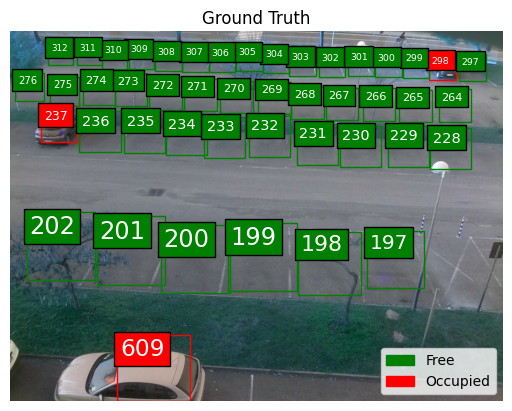

In [32]:
fixed_path = "content/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750"
path = r"/"+fixed_path+"/SUNNY/2015-11-12/camera5/2015-11-12_0746.jpg"

dim_BB = 1
print(f"img_path: {path}")
plot_image_with_bounding_boxes(path, dim_BB, verbose = True) #dim_bb è DIMENSIONE bb (1 = dimOrig, 0 = dim nulle)

##realizzare una funzione che esegue lo scan di tutte le immagini presenti nel dataset

In [ ]:
import os

def scan_every_picture(starting_path):
    '''
    Starting from the starting_path directory, scan every subdirectory and every image
    :param starting_path: path to scan
    '''
    list_of_img = []
    # Iterate over the directory tree
    for root, dirs, files in os.walk(starting_path):
        # Print the current directory
        print(f"Directory {root}")

        # Filter and print subdirectories
        subdirectories = [d for d in dirs]
        for subdirectory in subdirectories:
            print(f"\t SottoDirectory {subdirectory}")

        # Filter and print images
        images = [f for f in files if f.endswith(".jpg")]
        for image in images:
            print(f"\t\t Immagine {image}")
            # Get full path of the image
            image_path = os.path.join(root, image)
            print(f"\t\t\t {image_path}")

            list_of_img.append(image_path)

    for image_path in list_of_img:
      print(f"image_path: {image_path}")
      plot_image_with_bounding_boxes(image_path, dim_bb = 1, verbose = False)
      print("\n")
    return list_of_img



starting_path = "/content/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750"
scan_every_picture(starting_path)